# Import packages

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Camera Calibration

In [2]:
def camera_calibration(images,nx,ny):
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((ny*nx,3), np.float32)
    objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)
    
    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    
    # Step through the list and search for chessboard corners
    for fname in images:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)

            # Draw and display the corners
            img = cv2.drawChessboardCorners(img,(nx,ny),corners,ret)
            cv2.imshow('img',img)
    
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return ret, mtx, dist, rvecs, tvecs

# Do the correction
def undistort(img, mtx, dist, display = 1):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    if display:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(undist)
        ax2.set_title('Undistorted Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return undist

In [3]:
# Make a list of calibration images for calibration
images = glob.glob("camera_cal/calibration*.jpg")
ret, mtx, dist, rvecs, tvecs = camera_calibration(images,9,6)

True

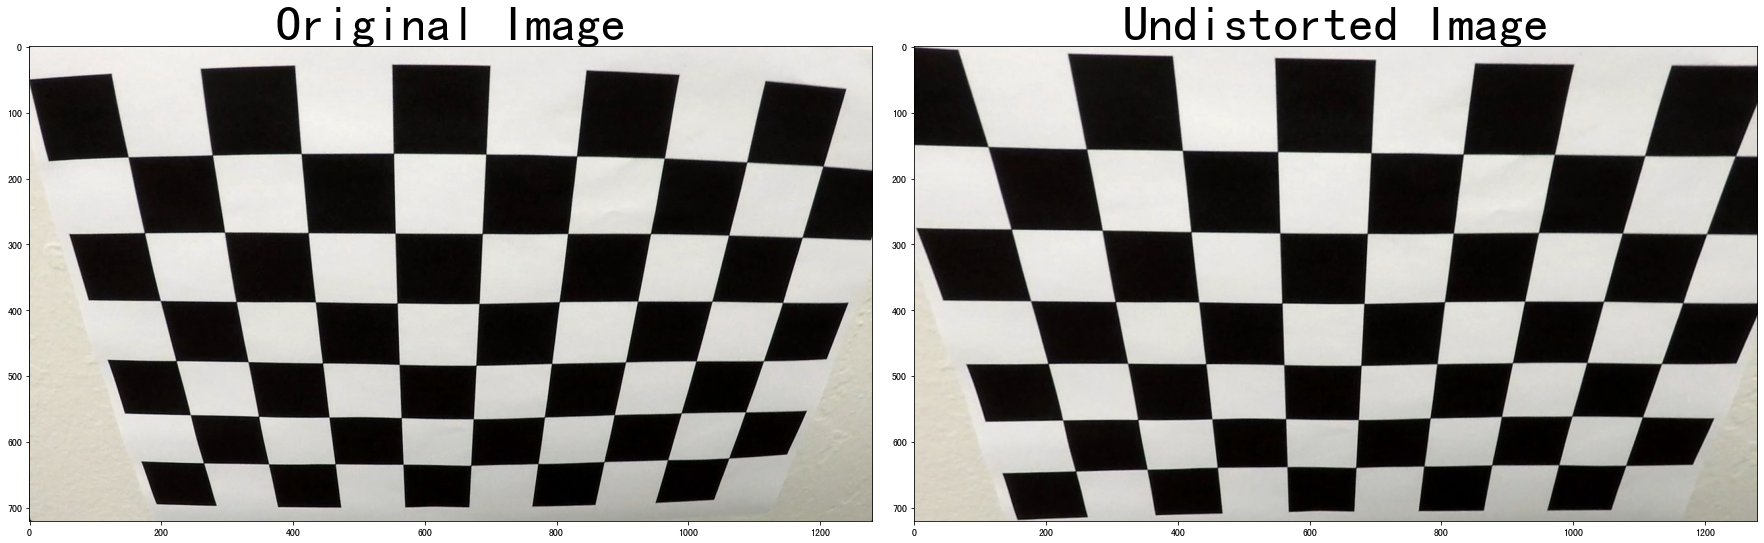

In [4]:
# Undistortion Test1
img = cv2.imread('camera_cal/calibration2.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_undistorted = undistort(img, mtx, dist)
cv2.imwrite("output_images/calibration2.jpg", cv2.cvtColor(img_undistorted, cv2.COLOR_RGB2BGR))

True

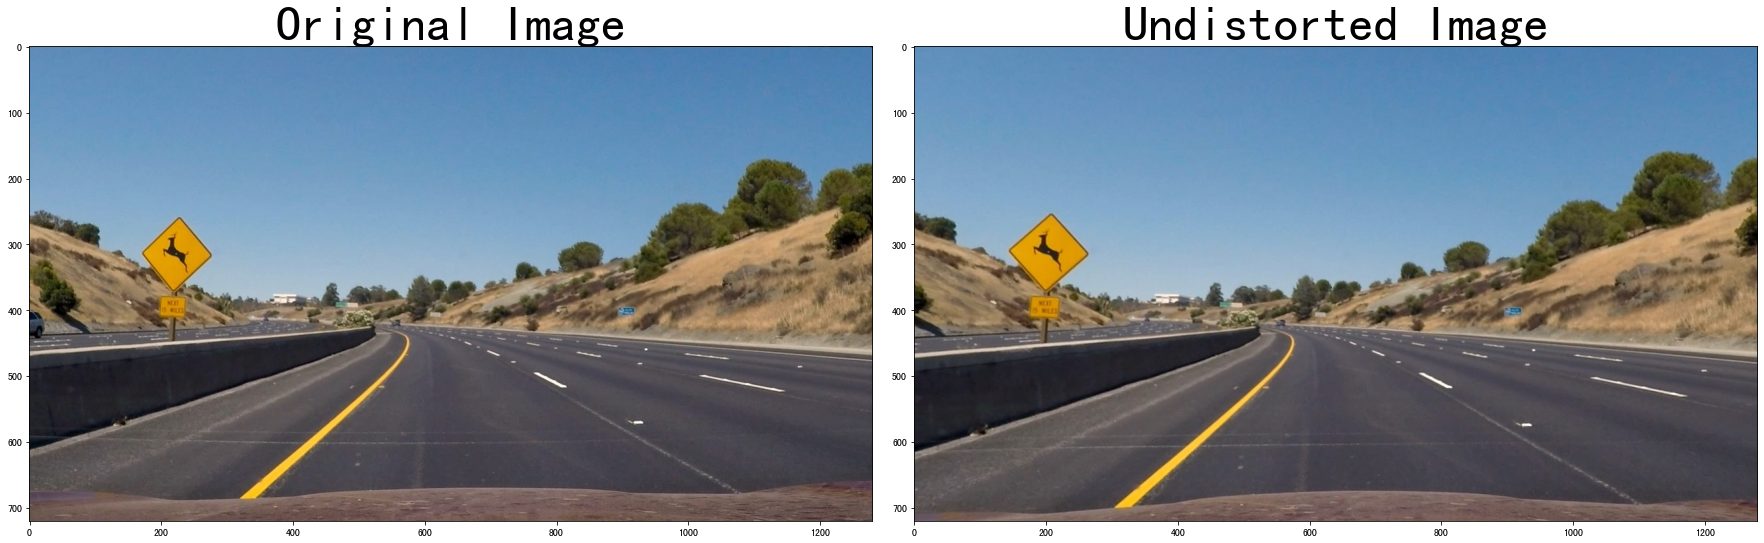

In [5]:
# Undistortion Test2
img = cv2.imread('test_images/test2.jpg')
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_undistorted = undistort(img, mtx, dist)
cv2.imwrite("output_images/test2.jpg", cv2.cvtColor(img_undistorted, cv2.COLOR_RGB2BGR))

# Thresholds

In [6]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    elif orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
        
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
        # is > thresh_min and < thresh_max
    grad_binary = np.zeros_like(scaled_sobel)
    grad_binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Calculate the magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8)
    
    # 5) Create a binary mask where mag thresholds are met
    grad_binary = np.zeros_like(gradmag)
    grad_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return grad_binary

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # 3) Take the absolute value of the x and y gradients
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    # 5) Create a binary mask where direction thresholds are met
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    return dir_binary

def hls_select(img, channel, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    
    # 2) Apply a threshold to the channel
    channel = hls[:,:,channel]
    
    # 3) Return a binary image of threshold result
    binary_output = np.zeros_like(channel)
    binary_output[(channel > thresh[0]) & (channel <= thresh[1])] = 1
    return binary_output

True

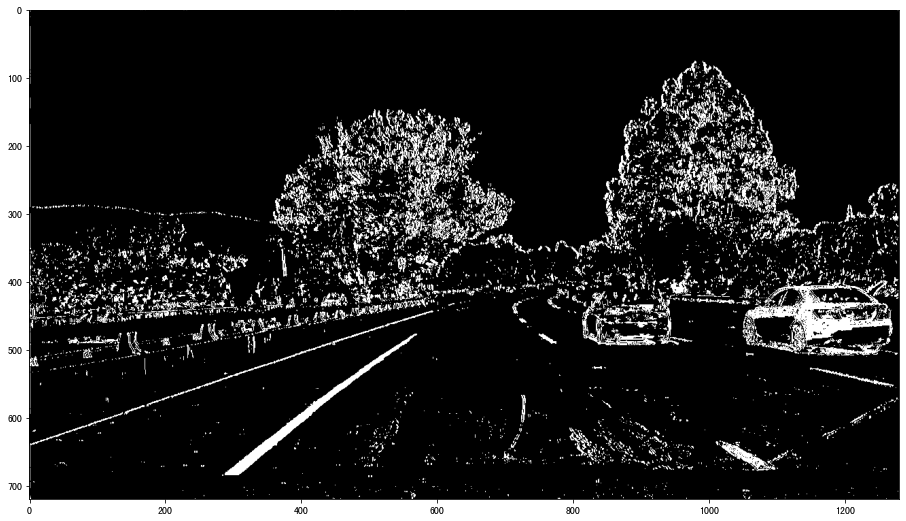

In [7]:
# Read in an image and grayscale it
image = mpimg.imread('test_images/test1.jpg')

# Choose a Sobel kernel size
ksize = 3 # Choose a larger odd number to smooth gradient measurements

# Apply each of the thresholding functions
gradx = abs_sobel_thresh(image, orient='x', sobel_kernel=ksize, thresh=(20, 100))
#grady = abs_sobel_thresh(image, orient='y', sobel_kernel=ksize, thresh=(20, 100))
#mag_binary = mag_thresh(image, sobel_kernel=ksize, mag_thresh=(20, 100))
#dir_binary = dir_threshold(image, sobel_kernel=ksize, thresh=(0.7, 1.3))
s_binary = hls_select(image, 2,(170, 255))

# Check the result
combined = np.zeros_like(s_binary)
combined[(gradx == 1) | (s_binary == 1)] = 1
plt.figure(figsize = (24,9))
plt.imshow(combined, cmap='gray')
cv2.imwrite("output_images/test1.jpg", combined*255)

# Perspective transform

In [8]:
def warper(img):
    
    # Compute and apply perpective transform
    h, w = img.shape[:2]
    
    src = np.float32([[w, h-10],
                      [0, h-10],
                      [550, 460],
                      [730, 460]])
    dst = np.float32([[w, h],
                      [0, h],
                      [0, 0],
                      [w, 0]])
    
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_NEAREST)  # keep same size as input image

    return warped, M, Minv

True

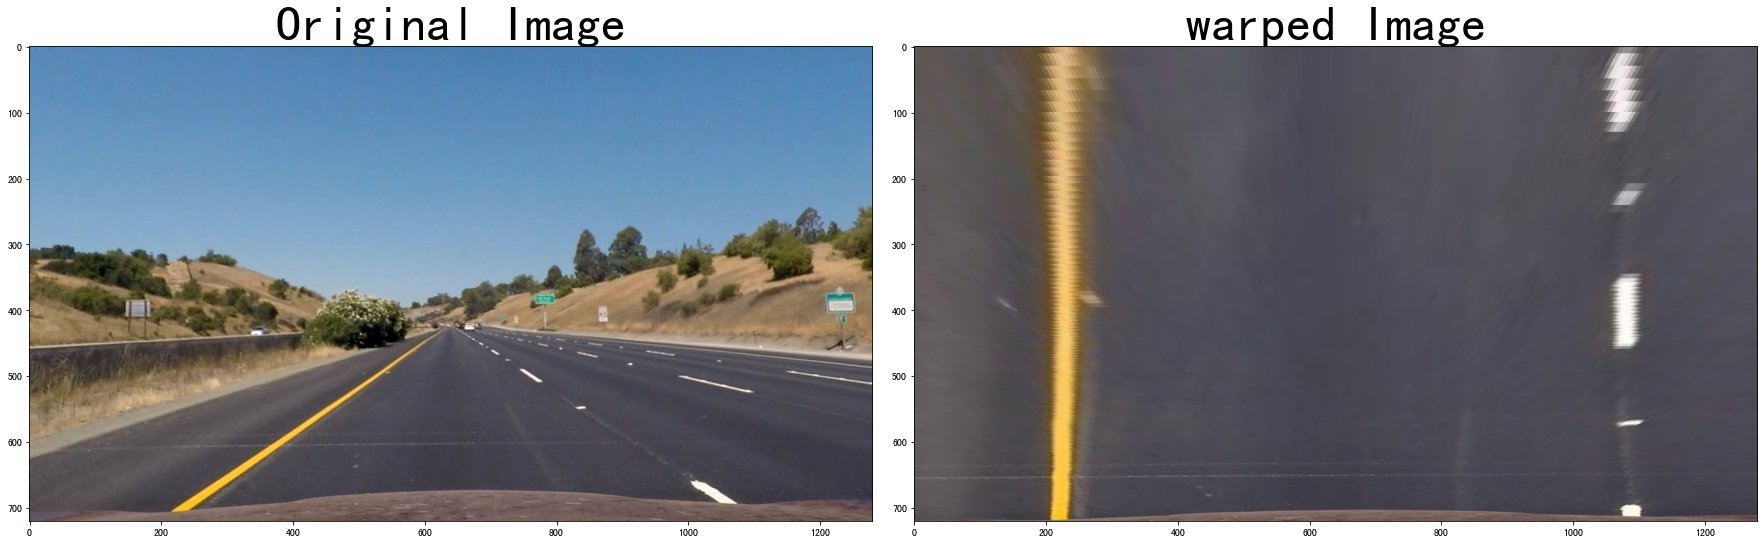

In [9]:
img = cv2.imread("test_images/straight_lines1.jpg")
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img_undistorted = undistort(img, mtx, dist, 0)
warped, M, Minv = warper(img_undistorted)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_undistorted)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(warped)
ax2.set_title('warped Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
cv2.imwrite("output_images/warped_straight_lines1.jpg", cv2.cvtColor(warped, cv2.COLOR_RGB2BGR))

# Identifying Lane-line Pixels

In [10]:
def find_lane_pixels(binary_warped):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        # Find the four below boundaries of the window ###
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img


def fit_polynomial(binary_warped):
    # Find our lane pixels first
    leftx, lefty, rightx, righty, out_img = find_lane_pixels(binary_warped)

    # Fit a second order polynomial to each using `np.polyfit` ###
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    cv2.line(out_img, (int(left_fitx[0]), int(ploty[0])), (int(left_fitx[-1]), int(ploty[-1])), color=[255, 255, 0], thickness=6)
    cv2.line(out_img, (int(right_fitx[0]), int(ploty[0])), (int(right_fitx[-1]), int(ploty[-1])), color=[255, 255, 0], thickness=6)

    return out_img, left_fit, right_fit, ploty

D:\anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
D:\anaconda\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20

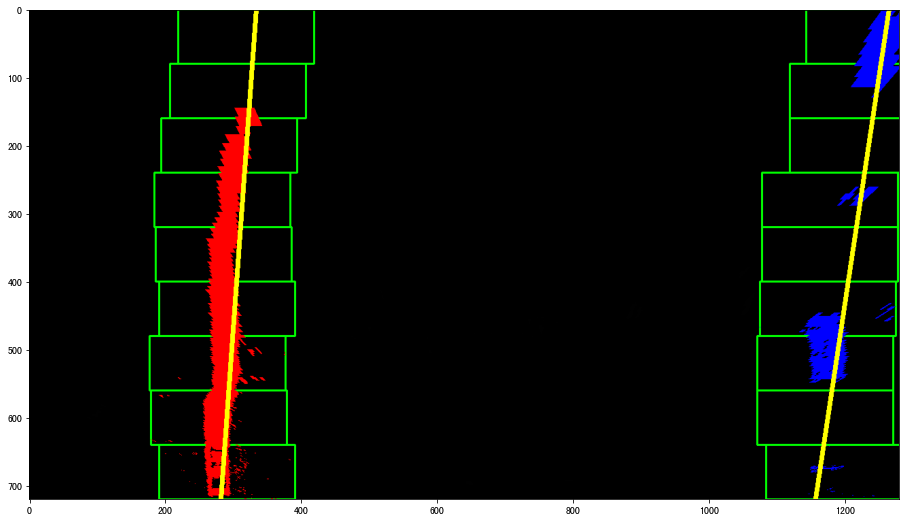

In [11]:
# Load our image
img = mpimg.imread('test_images/test4.jpg')

# Undistortion
img_undistorted = undistort(img, mtx, dist, 0)

# Set the shresholds
gradx = abs_sobel_thresh(img_undistorted, orient='x', sobel_kernel=ksize, thresh=(20, 100))
s_binary = hls_select(img_undistorted, 2,(170, 255))
combined = np.zeros_like(s_binary)
combined[(gradx == 1) | (s_binary == 1)] = 1

# Pespective Transform
warped, M, Minv = warper(combined)

# Sliding Windows
windows, left_fit, right_fit, ploty = fit_polynomial(warped)
cv2.imwrite("output_images/pixels_test4.jpg", cv2.cvtColor(windows, cv2.COLOR_RGB2BGR))
plt.figure(figsize = (24,9))
plt.imshow(windows)

# CurveRatius Calculation

In [12]:
def measure_curvature_real(left_fit, right_fit, ploty):
    '''
    Calculates the curvature of polynomial functions in meters.
    '''
    # Define y-value where we want radius of curvature
    # We'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension    
    
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Fit a second order polynomial to pixel positions in each fake lane line
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    
    # Calculation of R_curve (radius of curvature)
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    ratius = (left_curverad + right_curverad)/2
    
    left_lane_bottom = (left_fit[0]*y_eval)**2 + left_fit[0]*y_eval + left_fit[2]
    right_lane_bottom = (right_fit[0]*y_eval)**2 + right_fit[0]*y_eval + right_fit[2]
    
    # Calculation of current offset
    offset = ((left_lane_bottom + right_lane_bottom)/2 - 640)*xm_per_pix
    
    return ratius, offset

In [13]:
# Load our image
img = mpimg.imread('test_images/test4.jpg')

# Undistortion
img_undistorted = undistort(img, mtx, dist, 0)

# Set the shresholds
gradx = abs_sobel_thresh(img_undistorted, orient='x', sobel_kernel=ksize, thresh=(20, 100))
s_binary = hls_select(img_undistorted, 2,(170, 255))
combined = np.zeros_like(s_binary)
combined[(gradx == 1) | (s_binary == 1)] = 1

# Pespective Transform
warped, M, Minv = warper(combined)

# Sliding Windows
windows, left_fit, right_fit, ploty = fit_polynomial(warped)

# Curve Calculation
ratius, offset = measure_curvature_real(left_fit, right_fit, ploty)
print(ratius, 'm', offset, 'm')

1259.6918516874755 m 0.8475785085968168 m


D:\anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
D:\anaconda\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20

# Display like sample

In [14]:
def draw_lines(undist,warped,left_fit,right_fit):
    
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero,warp_zero,warp_zero))
    
    ploty = np.linspace(0,warped.shape[0]-1,warped.shape[0])
    left_fitx = left_fit[0] * ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0] * ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 100, 0))
    cv2.line(color_warp, (int(left_fitx[0]), int(ploty[0])), (int(left_fitx[-1]), int(ploty[-1])), color=[255, 0, 0], thickness=30)
    cv2.line(color_warp, (int(right_fitx[0]), int(ploty[0])), (int(right_fitx[-1]), int(ploty[-1])), color=[0, 0, 255], thickness=30)
    
    newwarp = cv2.warpPerspective(color_warp, Minv, (color_warp.shape[1], color_warp.shape[0]))
    
    result = cv2.addWeighted(undist, 1, newwarp, 0.5, 0)
    return result

def process_image(img):
    # Undistortion
    img_undistorted = undistort(img, mtx, dist, 0)

    # Set the shresholds
    gradx = abs_sobel_thresh(img_undistorted, orient='x', sobel_kernel=ksize, thresh=(20, 100))
    s_binary = hls_select(img_undistorted, 2,(170, 255))
    combined = np.zeros_like(s_binary)
    combined[(gradx == 1) | (s_binary == 1)] = 1

    # Pespective Transform
    warped, M, Minv = warper(combined)

    # Sliding Windows
    windows, left_fit, right_fit, ploty = fit_polynomial(warped)

    # Curve Calculation
    ratius, offset = measure_curvature_real(left_fit, right_fit, ploty)
    
    # Write the info
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_undistorted,'Ratius of Curvature = %d(m)' % ratius,(50,50),font,1,(255,255,255),2)
    if offset < 0:
        direc = 'left'
    else:
        direc = 'right'
    cv2.putText(img_undistorted,'Vehicle is %.2fm %s of center'%(np.abs(offset),direc),(50,100),font,1,(255,255,255),2)
    
    # Draw Lines
    result = draw_lines(img_undistorted,warped,left_fit,right_fit)
    
    return result

D:\anaconda\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  
D:\anaconda\lib\site-packages\ipykernel_launcher.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20

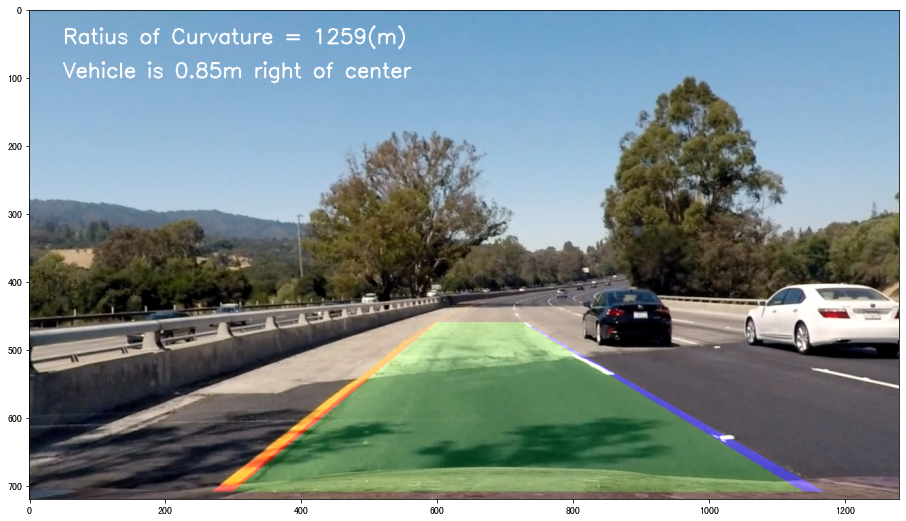

In [15]:
img = mpimg.imread('test_images/test4.jpg')
output = process_image(img)
cv2.imwrite("output_images/output_test4.jpg", cv2.cvtColor(output, cv2.COLOR_RGB2BGR))
plt.figure(figsize = (24,9))
plt.imshow(output)

# Test on video

In [16]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [17]:
white_output = 'output_videos/project_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

Moviepy - Building video output_videos/project_video.mp4.
Moviepy - Writing video output_videos/project_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/project_video.mp4
Wall time: 2min 1s


In [18]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

In [19]:
challenge_output = 'output_videos/challenge_video.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip2 = VideoFileClip('challenge_video.mp4')
challenge_clip = clip2.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

Moviepy - Building video output_videos/challenge_video.mp4.
Moviepy - Writing video output_videos/challenge_video.mp4



Moviepy - Done !
Moviepy - video ready output_videos/challenge_video.mp4
Wall time: 43.1 s


In [20]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))